<a href="https://colab.research.google.com/github/BelloFaheedah/Big-Data-Analysis/blob/main/NYC_Bike_Share_History.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NYC Bike Share Trip History**


This task is based on the trips taken by customers from publicly available stations. The dataset includes the following columns:
* Trip duration (seconds)
* Start and end date and time
* Start and end station name, ID, latitude, longitude
* Bike ID
* User type (“Customer” = 24-hour or 7-day pass user; “Subscriber” = annual member)
* Gender (0=unknown; 1=male; 2=female)
* Year of birth 
Source: NYC DOT https://www.nyc.gov/html/dot/downloads/misc/201401-citibike-tripdata.zip


The research question for this task is: "Riders ride longer on weekends than weekdays" 

NB: The previously provided dataset will be merged with this current one.

In [1]:
#installing pyspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=6b58da0bebee39d997e0a7b775b3434c9f98ea93bddafd7f13358ea34f7212d9
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("NYCDurationAnalysis") \
    .getOrCreate()


In [3]:
!wget https://www.nyc.gov/html/dot/downloads/misc/201401-citibike-tripdata.zip
!unzip 201401-citibike-tripdata.zip

--2023-05-24 15:41:25--  https://www.nyc.gov/html/dot/downloads/misc/201401-citibike-tripdata.zip
Resolving www.nyc.gov (www.nyc.gov)... 23.62.89.179, 2600:1406:3c:383::1500, 2600:1406:3c:38e::1500
Connecting to www.nyc.gov (www.nyc.gov)|23.62.89.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9697309 (9.2M) [application/zip]
Saving to: ‘201401-citibike-tripdata.zip’

201401-citibike-tri 100%[===================>]   9.25M  27.4MB/s    in 0.3s    

2023-05-24 15:41:26 (27.4 MB/s) - ‘201401-citibike-tripdata.zip’ saved [9697309/9697309]

Archive:  201401-citibike-tripdata.zip
  inflating: 2014-01 - Citi Bike trip data.csv  


In [5]:
#downloading and unzipping the dataset
!wget https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip
!unzip cyclehireusagestats-2014.zip


--2023-05-24 15:42:03--  https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip
Resolving cycling.data.tfl.gov.uk (cycling.data.tfl.gov.uk)... 104.16.100.13, 104.16.101.13
Connecting to cycling.data.tfl.gov.uk (cycling.data.tfl.gov.uk)|104.16.100.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225215129 (215M) [application/zip]
Saving to: ‘cyclehireusagestats-2014.zip.1’

cyclehireusagestats 100%[===================>] 214.78M   118MB/s    in 1.8s    

2023-05-24 15:42:05 (118 MB/s) - ‘cyclehireusagestats-2014.zip.1’ saved [225215129/225215129]

Archive:  cyclehireusagestats-2014.zip
  inflating: 1. Journey Data Extract 05Jan14-02Feb14.csv  
  inflating: 10a. Journey Data Extract 14Sep14-27Sep14.csv  
  inflating: 10b. Journey Data Extract 28Sep14-11Oct14.csv  
  inflating: 11a. Journey Data Extract 12Oct14-08Nov14.csv  
  inflating: 11b. Journey Data Extract 12Oct14-08Nov14.csv  
  inflating: 12a. Journey Data Extract 09Nov14-06Dec14.csv  

In [6]:
# checking out the directory path and the file names in the directory
import os

# Get the current directory path
directory_path = os.getcwd()
print("Directory Path:", directory_path)

# List all the files in the current directory
file_names = os.listdir(directory_path)
print("File Names:", file_names)


Directory Path: /content
File Names: ['.config', '11a. Journey Data Extract 12Oct14-08Nov14.csv', '12b. Journey Data Extract 09Nov14-06Dec14.csv', '13a. Journey Data Extract 07Dec14-21Dec14.csv', '201401-citibike-tripdata.zip', '1. Journey Data Extract 05Jan14-02Feb14.csv', '6. Journey Data Extract 25May14-21Jun14.csv', '4. Journey Data Extract 01Apr14-26Apr14.csv', '2. Journey Data Extract 03Feb14-01Mar14.csv', '10b. Journey Data Extract 28Sep14-11Oct14.csv', '8b Journey Data Extract 01Aug14-16Aug14.csv', '5. Journey Data Extract 27Apr14-24May14.csv', '14. Journey Data Extract 08Dec13-04Jan14.csv', 'cyclehireusagestats-2014.zip', '7. Journey Data Extract 22Jun14-19Jul14.csv', 'cyclehireusagestats-2014.zip.1', '10a. Journey Data Extract 14Sep14-27Sep14.csv', '12a. Journey Data Extract 09Nov14-06Dec14.csv', '9b Journey Data Extract 01Sep14-13Sep14.csv', '11b. Journey Data Extract 12Oct14-08Nov14.csv', '8a Journey Data Extract 20Jul14-31Jul14.csv', '2014-01 - Citi Bike trip data.csv', '9

In [7]:
#merging the dataset and 
from pyspark.sql import SparkSession
from functools import reduce

# Define the directory path where the files are located
directory_path = "/content"  # Change this to the correct directory if needed

# List all the files in the directory
file_names = ["8b Journey Data Extract 01Aug14-16Aug14.csv",
              "2. Journey Data Extract 03Feb14-01Mar14.csv",
              "9a Journey Data Extract 17Aug14-31Aug14.csv",
              "6. Journey Data Extract 25May14-21Jun14.csv",
              "1. Journey Data Extract 05Jan14-02Feb14.csv",
              "3. Journey Data Extract 02Mar14-31Mar14.csv",
              "8a Journey Data Extract 20Jul14-31Jul14.csv",
              "4. Journey Data Extract 01Apr14-26Apr14.csv",
              "cyclehireusagestats-2014.zip",
              "12b. Journey Data Extract 09Nov14-06Dec14.csv",
              "12a. Journey Data Extract 09Nov14-06Dec14.csv",
              "14. Journey Data Extract 08Dec13-04Jan14.csv",
              "10a. Journey Data Extract 14Sep14-27Sep14.csv",
              "11b. Journey Data Extract 12Oct14-08Nov14.csv",
              "7. Journey Data Extract 22Jun14-19Jul14.csv",
              "11a. Journey Data Extract 12Oct14-08Nov14.csv",
              "9b Journey Data Extract 01Sep14-13Sep14.csv",
              "5. Journey Data Extract 27Apr14-24May14.csv",
              "13a. Journey Data Extract 07Dec14-21Dec14.csv",
              "10b. Journey Data Extract 28Sep14-11Oct14.csv",
              "13b. Journey Data Extract 22Dec14-03Jan15.csv",
              "sample_data"]

# Filter the file names based on the keyword
csv_files = [file_name for file_name in file_names if "Journey Data Extract" in file_name]

# Read each file and store them as separate DataFrames
dataframes = []
for file_name in csv_files:
    file_path = f"{directory_path}/{file_name}"
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    # Select only the common columns for merging
    common_columns = ["Rental Id", "Duration", "Bike Id", "End Date", "EndStation Id", "EndStation Name",
                      "Start Date", "StartStation Id", "StartStation Name"]
    df = df.select(*common_columns)
    dataframes.append(df)

# Merge all DataFrames into a single DataFrame
tfl_df = reduce(lambda df1, df2: df1.union(df2), dataframes)


In [8]:
#reading the nyc data
nyc = spark.read.csv('/content/2014-01 - Citi Bike trip data.csv', header=True, inferSchema=True)
nyc.printSchema()


root
 |-- tripduration: integer (nullable = true)
 |-- starttime: timestamp (nullable = true)
 |-- stoptime: timestamp (nullable = true)
 |-- start station id: integer (nullable = true)
 |-- start station name: string (nullable = true)
 |-- start station latitude: double (nullable = true)
 |-- start station longitude: double (nullable = true)
 |-- end station id: integer (nullable = true)
 |-- end station name: string (nullable = true)
 |-- end station latitude: double (nullable = true)
 |-- end station longitude: double (nullable = true)
 |-- bikeid: integer (nullable = true)
 |-- usertype: string (nullable = true)
 |-- birth year: string (nullable = true)
 |-- gender: integer (nullable = true)



In [9]:
#renaming the columns to conform with that of tfl_df
# Assuming df is the DataFrame and 'old_column_name' is the current column name
nyc = nyc.withColumnRenamed('starttime', 'Start Date')
nyc = nyc.withColumnRenamed('bikeid', 'Bike Id')
nyc = nyc.withColumnRenamed('start station id', 'StartStation Id')
nyc = nyc.withColumnRenamed('stoptime','End Date')
nyc = nyc.withColumnRenamed('tripduration', 'Duration')
nyc = nyc.withColumnRenamed('start station name', 'StartStation Name')
nyc = nyc.withColumnRenamed('end station name', 'EndStation Name')
nyc = nyc.withColumnRenamed('end station id', 'EndStation Id')
nyc = nyc.withColumnRenamed('end station name', 'EndStation Name')


    


In [11]:
#dropping some of the unnecessary columns
# Assuming df is the DataFrame and columns_to_drop is a list of column names to be dropped
columns_to_drop = ['usertype', 'birth year', 'end station longitude','end station id', 'start station longitude',  'start station latitude', 'end station latitude','gender' ]

# Drop the specified columns
nyc_df = nyc.drop(*columns_to_drop)


In [13]:
nyc_df.printSchema()

root
 |-- Duration: integer (nullable = true)
 |-- Start Date: timestamp (nullable = true)
 |-- End Date: timestamp (nullable = true)
 |-- StartStation Id: integer (nullable = true)
 |-- StartStation Name: string (nullable = true)
 |-- EndStation Id: integer (nullable = true)
 |-- EndStation Name: string (nullable = true)
 |-- Bike Id: integer (nullable = true)



In [14]:
tfl_df = tfl_df.drop('Rental Id')
tfl_df.printSchema()

root
 |-- Duration: integer (nullable = true)
 |-- Bike Id: integer (nullable = true)
 |-- End Date: string (nullable = true)
 |-- EndStation Id: integer (nullable = true)
 |-- EndStation Name: string (nullable = true)
 |-- Start Date: string (nullable = true)
 |-- StartStation Id: integer (nullable = true)
 |-- StartStation Name: string (nullable = true)



In [15]:
#aligning both dataset accordingly
tfl_df_aligned =tfl_df.select('Duration', 'Bike Id', 'End Date', 'EndStation Id','EndStation Name', 'Start Date', 'StartStation Id', 'StartStation Name')
nyc_data_aligned =nyc_df.select('Duration', 'Bike Id', 'End Date', 'EndStation Id','EndStation Name', 'Start Date', 'StartStation Id', 'StartStation Name')

In [17]:
# Convert the "Start Date" and "End Date" column to DateType in both datasets

from pyspark.sql.functions import to_date, month, when

tfl_df = tfl_df.withColumn("Start Date", to_date("Start Date", "dd/MM/yyyy HH:mm"))
tfl_df = tfl_df.withColumn("End Date", to_date("End Date", "dd/MM/yyyy HH:mm"))
nyc_df= nyc_df.withColumn("Start Date", to_date("Start Date", "dd/MM/yyyy HH:mm"))
nyc_df= nyc_df.withColumn("End Date", to_date("End Date", "dd/MM/yyyy HH:mm"))

In [18]:
#joining both dataframes
merged_df= nyc_data_aligned.union(tfl_df_aligned)
merged_df.printSchema()

root
 |-- Duration: integer (nullable = true)
 |-- Bike Id: integer (nullable = true)
 |-- End Date: string (nullable = true)
 |-- EndStation Id: integer (nullable = true)
 |-- EndStation Name: string (nullable = true)
 |-- Start Date: string (nullable = true)
 |-- StartStation Id: integer (nullable = true)
 |-- StartStation Name: string (nullable = true)



In [19]:
merged_df.show()

+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+
|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|
+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+
|     471|  16379|2014-01-01 00:07:57|          263|Elizabeth St & He...|2014-01-01 00:00:06|           2009|Catherine St & Mo...|
|    1494|  15611|2014-01-01 00:25:32|          259|South St & Whiteh...|2014-01-01 00:00:38|            536|     1 Ave & E 30 St|
|     464|  16613|2014-01-01 00:11:43|         2022| E 59 St & Sutton Pl|2014-01-01 00:03:59|            228|     E 48 St & 3 Ave|
|     373|  15938|2014-01-01 00:11:28|          526|     E 33 St & 5 Ave|2014-01-01 00:05:15|            519|   Pershing Square N|
|     660|  19830|2014-01-01 00:16:18|          436|Hancock St & Bedf...|2014-01-01

In [20]:
merged_df.count()

11781996

In [21]:
#dropping rows with missing values in columns Duration and Start Date
merged_df.dropna(subset=["Start Date", "Duration"])  
merged_df.count()

11781996

The above result implies that there is no missing values in both columns

In [23]:
from pyspark.sql.functions import dayofweek

df = merged_df.withColumn("Day of Week", dayofweek(merged_df["Start Date"]))
df.show()


+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+
|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|Day of Week|
+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+
|     471|  16379|2014-01-01 00:07:57|          263|Elizabeth St & He...|2014-01-01 00:00:06|           2009|Catherine St & Mo...|          4|
|    1494|  15611|2014-01-01 00:25:32|          259|South St & Whiteh...|2014-01-01 00:00:38|            536|     1 Ave & E 30 St|          4|
|     464|  16613|2014-01-01 00:11:43|         2022| E 59 St & Sutton Pl|2014-01-01 00:03:59|            228|     E 48 St & 3 Ave|          4|
|     373|  15938|2014-01-01 00:11:28|          526|     E 33 St & 5 Ave|2014-01-01 00:05:15|            519|   Pershing Square N|          4|

In [26]:
#classifying the weekdays and weekends
from pyspark.sql.functions import col
from pyspark.sql.functions import when

df = df.withColumn("Day Type", when(col("Day of Week").isin([2, 3, 4, 5, 6]), "Weekday").otherwise("Weekend"))
df.show()

+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+--------+
|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|Day of Week|Day Type|
+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+--------+
|     471|  16379|2014-01-01 00:07:57|          263|Elizabeth St & He...|2014-01-01 00:00:06|           2009|Catherine St & Mo...|          4| Weekday|
|    1494|  15611|2014-01-01 00:25:32|          259|South St & Whiteh...|2014-01-01 00:00:38|            536|     1 Ave & E 30 St|          4| Weekday|
|     464|  16613|2014-01-01 00:11:43|         2022| E 59 St & Sutton Pl|2014-01-01 00:03:59|            228|     E 48 St & 3 Ave|          4| Weekday|
|     373|  15938|2014-01-01 00:11:28|          526|     E 33 St & 5 Ave|2014-01-01 00:0

In [28]:
#filtering out the month January
from pyspark.sql.functions import month

df_january = df.filter(month(col("Start Date")) == 1)
df_january.show()


+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+--------+
|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|Day of Week|Day Type|
+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+--------+
|     471|  16379|2014-01-01 00:07:57|          263|Elizabeth St & He...|2014-01-01 00:00:06|           2009|Catherine St & Mo...|          4| Weekday|
|    1494|  15611|2014-01-01 00:25:32|          259|South St & Whiteh...|2014-01-01 00:00:38|            536|     1 Ave & E 30 St|          4| Weekday|
|     464|  16613|2014-01-01 00:11:43|         2022| E 59 St & Sutton Pl|2014-01-01 00:03:59|            228|     E 48 St & 3 Ave|          4| Weekday|
|     373|  15938|2014-01-01 00:11:28|          526|     E 33 St & 5 Ave|2014-01-01 00:0

In [29]:
df_january.count()

300400

In [47]:
#Calculating the averge duration for weekdays and weekends separately:

from pyspark.sql.functions import avg

result = df_january.groupBy("Day Type").agg(avg("Duration").alias("Average Duration"))
result.show()


+--------+-----------------+
|Day Type| Average Duration|
+--------+-----------------+
| Weekday|722.5834680483034|
| Weekend|787.1593535231478|
+--------+-----------------+



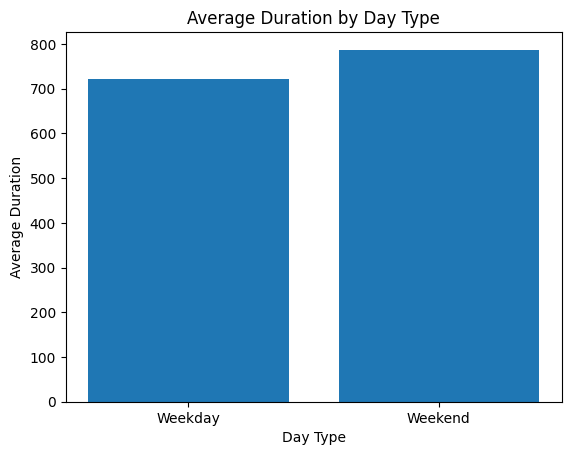

In [48]:
#visualizing the result
#visualizing the result of the total duration for weekday weekend
import matplotlib.pyplot as plt

# Convert the season_duration DataFrame to Pandas DataFrame
result_pandas = result.toPandas()

# Plot the bar chart
plt.bar(result_pandas["Day Type"], result_pandas["Average Duration"])
plt.xlabel("Day Type")
plt.ylabel("Average Duration")
plt.title("Average Duration by Day Type")
plt.show()

Statistical analysis

In [32]:
#Splitting the dataset into separate DataFrames for weekdays and weekends:

df_weekdays = df_january.filter(col("Day Type") == "Weekday")
df_weekends = df_january.filter(col("Day Type") == "Weekend")


In [46]:
print(df_weekdays.count())
print(df_weekends.count())

247436
52964


In [33]:
#Calculating the mean duration for weekdays and weekends:
from pyspark.sql.functions import avg

mean_weekdays = df_weekdays.select(avg("Duration")).first()[0]
mean_weekends = df_weekends.select(avg("Duration")).first()[0]


In [44]:
print(mean_weekdays)
print(mean_weekends)


722.5834680483034
787.1593535231478


In [34]:
#Calculating the standard deviation for weekdays and weekends:
from pyspark.sql.functions import stddev

stddev_weekdays = df_weekdays.select(stddev("Duration")).first()[0]
stddev_weekends = df_weekends.select(stddev("Duration")).first()[0]


In [39]:
print(stddev_weekdays)
print(stddev_weekends)


5269.030187717514
5282.543622591171


In [42]:
#Performing the t-test using the means and standard deviations:

from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(df_weekdays.select("Duration").rdd.flatMap(lambda x: x).collect(),
                                 df_weekends.select("Duration").rdd.flatMap(lambda x: x).collect(),
                                 alternative='less',
                                 equal_var=False)



In [43]:
print(t_statistic)
print(p_value)

-2.554435034338438
0.005318965025789005


**Decision Making**

*Null Hypothesis (H0)*: The average duration of bike rides on weekends is equal to or shorter than the average duration on weekdays in January.

*Alternative Hypothesis (H1)*: The average duration of bike rides on weekends is longer than the average duration on weekdays in January.

**Decision Rule**

If the p-value is less than the significance level (e.g., 0.05), it suggests that there is a significant difference in the mean durations between weekdays and weekends in January.
If the p-value is greater than the significance level, it indicates that there is not enough evidence to conclude a significant difference.

**Conclusion**

Since the p-value is less than 0.05 (i.e. 0.00532 < 0.05), the null hypothesis is rejected and thus, the conclusion is that **The average duration of bike rides on weekends is longer than the average duration of bike rides on weekdays**